# Jupyter Notebook for Main Results

Running this notebook will re-produce the main results from this project. As the actual model training was quite computational-heavy and would not be feasible to include in this notebook, it will load precomputed tokenization splits and training logs from the repository to recreate the main figures and results.

In [15]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from collections import Counter
import seaborn as sns
sns.set(style='whitegrid')
from pathlib import Path
import sys
repo_root = Path.cwd().parent.resolve()
sys.path.insert(0, str(repo_root / 'pipeline'))
from evaluate_dataset import calculate_depth, count_operators # type: ignore[import]


## Initial Dataset Statistics
This section loads the 10,000 synthethized equations and reproduces dataset statistics figures used in the report. The CSV used here is `HPC pipeline/data/equations.csv`. 

Sample equations: 

m_2=ln(c+y_rms+R)
F=log(4/3-c+b+n^n-phi_0)-exp(V-v_min^+-tau)-1/2-N_A-gamma_min*alpha*W+log(k+A_i+mu+w)
B=L^3
b_net=tan(R-gamma)
z=(theta_0)/(2/3+z_2)


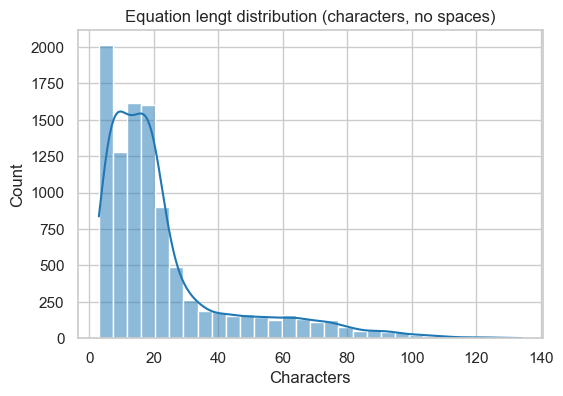

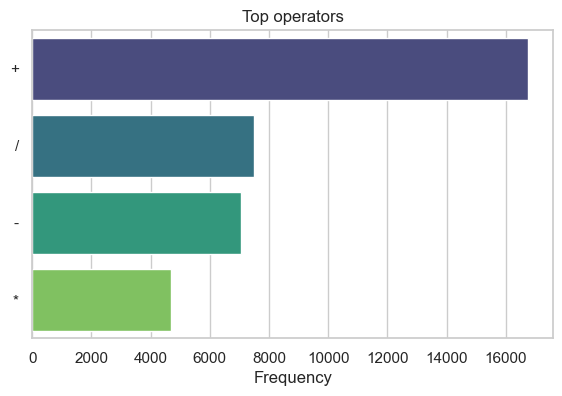

In [16]:
# Load pre-tokenized data
all_equations = repo_root / 'pipeline' / 'data' / 'equations.csv'
df = pd.read_csv(all_equations)
eq_col = 'full_equation'
df['char_len'] = df[eq_col].fillna('').map(lambda s: len(s.replace(' ', '')) if isinstance(s, str) else 0)

# Print a few sample equations
print("Sample equations: \n", )
for eq in df[eq_col].dropna().sample(5, random_state=42).values:
    print(eq)

# Depth and operators
df['depth'] = df[eq_col].fillna('').map(lambda s: calculate_depth(s) if isinstance(s, str) else 0)
df['operators'] = df[eq_col].fillna('').map(lambda s: count_operators(s) if isinstance(s, str) else [])

op_counter = Counter()
for ops in df['operators']:
    op_counter.update(ops)

# Plot: character length distribution
plt.figure(figsize=(6, 4))
sns.histplot(df['char_len'], bins=30, kde=True, color='tab:blue')
plt.title('Equation lengt distribution (characters, no spaces)')
plt.xlabel('Characters')
plt.show()

# Plot: top operators
ops, freqs = zip(*op_counter.most_common(10))
plt.figure(figsize=(6.72, 4))
sns.barplot(x=list(freqs), y=list(ops), palette='viridis')
plt.title('Top operators')
plt.xlabel('Frequency')
plt.show()


## Tokenization and Vocabulary
This section looks into the tokenization and resulting vocabularies. A summary table can be found beneath the code cell.

In [17]:
csv_path = repo_root / 'pipeline' / 'data' / 'tokenization' / 'token_stats.csv'
df = pd.read_csv(csv_path)

agg = df.groupby("tokenizer").agg(
    total_rows=("n_rows", "sum"),
    avg_tokens_mean=("avg_tokens", "mean"),
    std_tokens_mean=("std_tokens", "mean"),
    min_tokens=("min_tokens", "min"),
    max_tokens=("max_tokens", "max"),
    avg_eq_chars_mean=("avg_eq_chars", "mean"),
    avg_chars_per_token_mean=("avg_chars_per_token", "mean"),
    vocab_size_mean=("vocab_size", "mean"),
    avg_unique_tokens_per_eq_mean=("avg_unique_tokens_per_eq", "mean")
).round(1)

print(agg)

              total_rows  avg_tokens_mean  std_tokens_mean  min_tokens  \
tokenizer                                                                
bpe                10000              7.6              7.0         2.0   
char               10000             23.0             21.0         3.0   
hierarchical       10000             41.0             34.5         7.0   

              max_tokens  avg_eq_chars_mean  avg_chars_per_token_mean  \
tokenizer                                                               
bpe                 45.0               23.0                       3.0   
char               134.0               23.0                       1.0   
hierarchical       251.0               23.0                       0.6   

              vocab_size_mean  avg_unique_tokens_per_eq_mean  
tokenizer                                                     
bpe                     745.3                            7.5  
char                     55.0                           14.7  
hierarchica

## Model Training Comparison

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


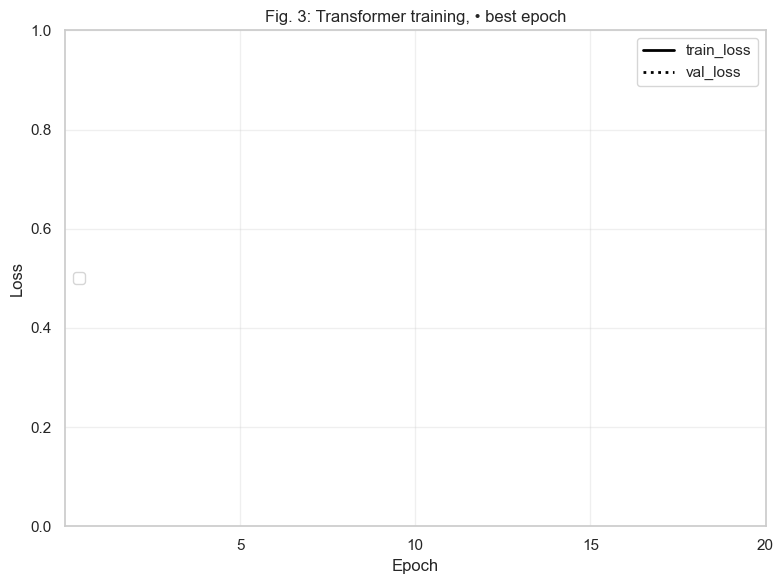

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


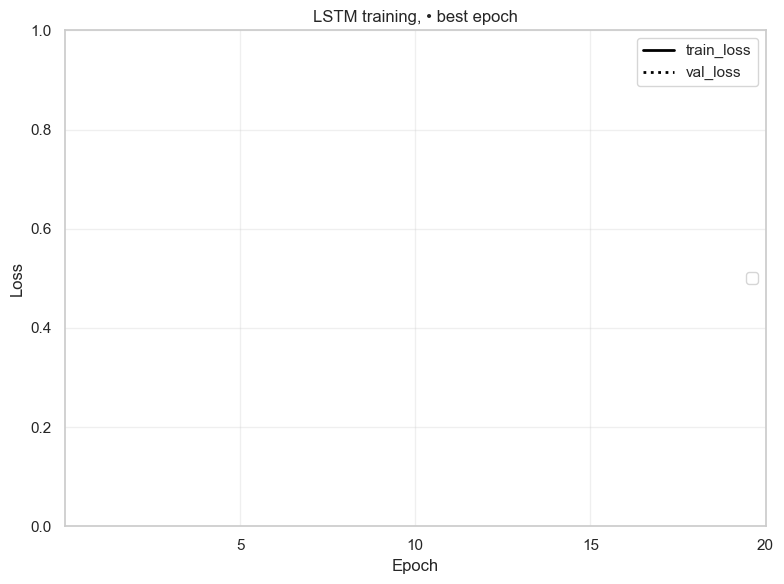

In [18]:
# Transformer training comparison
plt.figure(figsize=(8, 6))

runs = {
    'BPE_Me': 'transformer_bpe_medium',
    'BPE_Ti': 'transformer_bpe_tiny',
    'Char_Me': 'transformer_char_medium',
    'Char_Ti': 'transformer_char_tiny',
    'Hier_Me': 'transformer_hierarchical_medium',
    'Hier_Ti': 'transformer_hierarchical_tiny'
}

colors = {
    'BPE_Me': 'tab:blue',
    'BPE_Ti': 'tab:orange',
    'Char_Me': 'tab:green',
    'Char_Ti': 'tab:red',
    'Hier_Me': 'tab:purple',
    'Hier_Ti': 'tab:brown'
}

for label, run_name in runs.items():
    run_csv = repo_root / 'pipeline' / 'runs' / run_name / f'{run_name.replace("_medium", "").replace("_tiny", "")}.csv'
    
    if run_csv.exists():
        df_run = pd.read_csv(run_csv)
        color = colors[label]
       
        plt.plot(df_run['epoch'], df_run['train_loss'], 
                color=color, linestyle='-', label=label, linewidth=2)
        plt.plot(df_run['epoch'], df_run['val_loss'], 
                color=color, linestyle=':', linewidth=2)
        
        best_idx = df_run['val_loss'].idxmin()
        best_epoch = df_run.loc[best_idx, 'epoch']
        best_loss = df_run.loc[best_idx, 'val_loss']
        plt.scatter(best_epoch, best_loss, color=color, s=100, zorder=5)
    else:
        print(f'Warning: {run_csv} not found')

legend_elements = [
    Line2D([0], [0], color='black', linewidth=2, linestyle='-', label='train_loss'),
    Line2D([0], [0], color='black', linewidth=2, linestyle=':', label='val_loss')
]
first_legend = plt.legend(handles=legend_elements, loc='upper right')
plt.gca().add_artist(first_legend)

plt.legend(loc='center left')

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Fig. 3: Transformer training, • best epoch', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks([5, 10, 15, 20])
plt.tight_layout()
plt.show()

#________________________________________________________________________________________________________________________

# LSTM training comparison
plt.figure(figsize=(8, 6))

runs = {
    'BPE_Me': 'lstm_bpe_medium',
    'BPE_Ti': 'lstm_bpe_tiny',
    'Char_Me': 'lstm_char_medium',
    'Char_Ti': 'lstm_char_tiny',
    'Hier_Me': 'lstm_hierarchical_medium',
    'Hier_Ti': 'lstm_hierarchical_tiny'
}

colors = {
    'BPE_Me': 'tab:blue',
    'BPE_Ti': 'tab:orange',
    'Char_Me': 'tab:green',
    'Char_Ti': 'tab:red',
    'Hier_Me': 'tab:purple',
    'Hier_Ti': 'tab:brown'
}

for label, run_name in runs.items():
    tokenizer_type = run_name.replace('lstm_', '').replace('_medium', '').replace('_tiny', '')
    run_csv = repo_root / 'pipeline' / 'runs' / run_name / f'LSTM_{tokenizer_type}_epochs.csv'
    
    if run_csv.exists():
        df_run = pd.read_csv(run_csv)
        color = colors[label]
        
        plt.plot(df_run['epoch'], df_run['train_loss'], 
                color=color, linestyle='-', label=label, linewidth=2)
        plt.plot(df_run['epoch'], df_run['val_loss'], 
                color=color, linestyle=':', linewidth=2)
        
        best_idx = df_run['val_loss'].idxmin()
        best_epoch = df_run.loc[best_idx, 'epoch']
        best_loss = df_run.loc[best_idx, 'val_loss']
        plt.scatter(best_epoch, best_loss, color=color, s=100, zorder=5)
    else:
        print(f'Warning: {run_csv} not found')

legend_elements = [
    Line2D([0], [0], color='black', linewidth=2, linestyle='-', label='train_loss'),
    Line2D([0], [0], color='black', linewidth=2, linestyle=':', label='val_loss')
]
first_legend = plt.legend(handles=legend_elements, loc='upper right')
plt.gca().add_artist(first_legend)

plt.legend(loc='center right')

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('LSTM training, • best epoch', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks([5, 10, 15, 20])
plt.tight_layout()
plt.show()


## Evaluation of Models and Tokenizers
The best performing models within both LSTM and transformer were evaluated across size and tokenizers on 145 real physics equations. A summary table and plots are produced below.

In [19]:
#Load and display the evaluation results
run_csv = repo_root / 'pipeline' / 'model_eval_results_runs.csv'
if not run_csv.exists():
    print('Run CSV not found:', run_csv)
else:
    run_df = pd.read_csv(run_csv)
    display(run_df)


metrics = ['loss', 'perplexity', 'bpc', 'model_size_mb', 'num_parameters', 'token_per_sec']
model_metrics = {}

for metric in metrics:
    if metric in run_df.columns:
        if metric in ['loss', 'perplexity', 'bpc', 'model_size_mb', 'num_parameters']:
            best_row = run_df.loc[run_df[metric].idxmin()]
        else:
            best_row = run_df.loc[run_df[metric].idxmax()]

        model_id = f"{best_row['model_size']} {best_row['model_type']} {best_row['tokenization']}"

        if model_id not in model_metrics:
            model_metrics[model_id] = []
        model_metrics[model_id].append(metric)

for model, metrics_list in model_metrics.items():
    metrics_str = ', '.join(metrics_list)
    print(f"Best performing for {metrics_str}:")
    print(model)
    print()

,model_type,tokenization,model_size,loss,perplexity,bpc,model_size_mb,num_parameters,tokens_per_sec,checkpoint_path
0,lstm,bpe,medium,22.071906,3.852183e+09,15.583886,124.707497,32690445,378099.924123,HPC pipeline/runs\lstm_bpe_medium\best_model.pth
1,lstm,bpe,tiny,15.143084,3.771881e+06,10.691786,5.546669,1453325,698833.772262,HPC pipeline/runs\lstm_bpe_tiny\best_model.pth
2,lstm,char,medium,19.277174,2.354889e+08,26.134324,120.462563,31577657,372549.958692,HPC pipeline/runs\lstm_char_medium\best_model.pth
3,lstm,char,tiny,14.902700,2.965928e+06,20.203791,4.129860,1081913,642509.394321,HPC pipeline/runs\lstm_char_tiny\best_model.pth
4,lstm,hierarchical,medium,18.148209,7.614947e+07,24.603770,120.626747,31620693,379833.409252,HPC pipeline/runs\lstm_hierarchical_medium\bes...
5,lstm,hierarchical,tiny,9.534758,1.383224e+04,12.926399,4.184669,1096277,772279.019444,HPC pipeline/runs\lstm_hierarchical_tiny\best_...
6,transformer,bpe,medium,8.008203,3.005511e+03,5.654198,327.180788,85754112,107706.541655,HPC pipeline/runs\transformer_bpe_medium\best_...
7,transformer,bpe,tiny,7.473911,1.761483e+03,5.276961,12.959978,3392256,247955.074823,HPC pipeline/runs\transformer_bpe_tiny\best_tr...
8,transformer,char,medium,3.773504,4.353232e+01,5.115789,325.059839,85198080,144255.101521,HPC pipeline/runs\transformer_char_medium\best...
9,transformer,char,tiny,3.954513,5.217028e+01,5.361186,12.253000,3206912,321293.101787,HPC pipeline/runs\transformer_char_tiny\best_t...


Best performing for loss, perplexity, bpc:
medium transformer char

Best performing for model_size_mb, num_parameters:
tiny lstm char

